# Latent MSBM Vector Field Visualization

This notebook visualizes magnitude colormapped vector fields at **all time marginals** for MSBM policies.

Based on the evaluation script `scripts/latent_msbm_eval.py`.

**IMPORTANT**: If you see T=6 instead of T=7 after running cell 8, you need to:
1. Restart the kernel (to reload the updated `_load_data()` function)
2. Re-run all cells from the beginning

The fix keeps all 7 marginals including the first one for proper time consistency.

In [14]:
from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

# Add parent directory to path
path_root = Path.cwd().parent
if str(path_root) not in sys.path:
    sys.path.insert(0, str(path_root))

from scripts.utils import get_device
from mmsfm.latent_msbm import LatentMSBMAgent
from mmsfm.latent_msbm.noise_schedule import ConstantSigmaSchedule, ExponentialContractingSigmaSchedule
from scripts.latent_msbm_main import load_autoencoder, _load_data
from scripts.pca.pca_visualization_utils import parse_args_file
import argparse

print("Imports successful!")

Imports successful!


In [15]:
from sklearn.decomposition import PCA

# Additional imports for enhanced visualization
print("Additional imports loaded for PCA and ambient visualization")

Additional imports loaded for PCA and ambient visualization


In [16]:
def format_for_paper() -> None:
    """Apply publication-style defaults for matplotlib figures."""
    plt.rcParams.update({"image.cmap": "viridis"})
    plt.rcParams.update(
        {
            "font.serif": [
                "Times New Roman",
                "Times",
                "DejaVu Serif",
                "Bitstream Vera Serif",
                "Computer Modern Roman",
                "New Century Schoolbook",
                "Century Schoolbook L",
                "Utopia",
                "ITC Bookman",
                "Bookman",
                "Nimbus Roman No9 L",
                "Palatino",
                "Charter",
                "serif",
            ]
        }
    )
    plt.rcParams.update({"font.family": "serif"})
    plt.rcParams.update({"font.size": 10})
    plt.rcParams.update({"mathtext.fontset": "custom"})
    plt.rcParams.update({"mathtext.rm": "serif"})
    plt.rcParams.update({"mathtext.it": "serif:italic"})
    plt.rcParams.update({"mathtext.bf": "serif:bold"})
    plt.close("all")

# Apply paper formatting
format_for_paper()
print("✓ Applied paper formatting to all plots")

✓ Applied paper formatting to all plots


## Configuration

Set the path to your trained MSBM model directory.

In [17]:
# USER: Update this path to your MSBM training output directory
msbm_dir = Path("/data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42")

# Optional: Override parameters (will use args.txt from msbm_dir if available)
data_path = "./data/tran_inclusions.npz"  # Path to your data file
ae_checkpoint = "results/2026-01-23T17-16-56-39/geodesic_autoencoder_best.pth" # Path to autoencoder checkpoint
ae_type = "diffeo"  # "geodesic" or "diffeo"
test_size = None  # e.g., 0.2
seed = 42
nogpu = False

# Visualization settings
n_infer = 500  # Number of test samples to use
dims = (0, 1)  # Which latent dimensions to visualize
grid_size = 20  # Grid resolution for vector field
figsize_per_subplot = 5  # Size of each subplot

device = get_device(nogpu)
print(f"Using device: {device}")

Using cuda...
Using device: cuda


## Load Configuration from Training

In [18]:
# Load training configuration
train_cfg = {}
args_path = msbm_dir / "args.txt"
if args_path.exists():
    train_cfg = parse_args_file(args_path)
    print(f"Loaded training config from {args_path}")
else:
    print(f"Warning: args.txt not found in {msbm_dir}")

def _cfg(key: str, fallback):
    return train_cfg.get(key, fallback)

def _resolve_maybe(path_like):
    if path_like is None:
        return None
    p = Path(str(path_like)).expanduser()
    if p.is_absolute():
        return str(p)
    for base in (Path.cwd().parent, msbm_dir):
        cand = (base / p).resolve()
        if cand.exists():
            return str(cand)
    return str(p.resolve())

# Resolve paths
data_path = data_path or _cfg("data_path", None)
ae_checkpoint = ae_checkpoint or _cfg("ae_checkpoint", None)
ae_type = ae_type or _cfg("ae_type", "diffeo")
test_size = test_size if test_size is not None else _cfg("test_size", 0.2)

if data_path is None or ae_checkpoint is None:
    raise ValueError("Must provide data_path and ae_checkpoint")

data_path = _resolve_maybe(data_path)
ae_checkpoint = _resolve_maybe(ae_checkpoint)

# MSBM parameters
hidden = _cfg("hidden", [1024, 1024, 1024])
time_dim = _cfg("time_dim", 32)
policy_arch = _cfg("policy_arch", "resnet")
var = _cfg("var", 0.5)
var_schedule = _cfg("var_schedule", "constant")
var_decay_rate = _cfg("var_decay_rate", 2.0)
var_time_ref = _cfg("var_time_ref", None)
t_scale = _cfg("t_scale", 1.0)
interval = _cfg("interval", 100)
use_t_idx = _cfg("use_t_idx", False)
latent_dim_override = _cfg("latent_dim_override", 376)
ae_ode_method = _cfg("ae_ode_method", "dopri5")

print(f"Data path: {data_path}")
print(f"AE checkpoint: {ae_checkpoint}")
print(f"AE type: {ae_type}")
print(f"Policy architecture: {policy_arch}")

Loaded training config from /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/args.txt
Data path: /data1/jy384/research/MMSFM/data/tran_inclusions.npz
AE checkpoint: /data1/jy384/research/MMSFM/results/2026-01-23T17-16-56-39/geodesic_autoencoder_best.pth
AE type: diffeo
Policy architecture: resnet


## Load Data and Autoencoder

In [19]:
# Load data
load_ns = argparse.Namespace(
    data_path=data_path,
    test_size=test_size,
    seed=seed,
    use_cache_data=_cfg("use_cache_data", False),
    selected_cache_path=_cfg("selected_cache_path", None),
    cache_dir=_cfg("cache_dir", None),
)
x_train, x_test, zt = _load_data(load_ns)
T = int(x_test.shape[0])
zt_np = np.asarray(zt, dtype=np.float32)

print(f"Loaded data: T={T}, x_train.shape={x_train.shape}, x_test.shape={x_test.shape}")

# Load autoencoder
encoder, decoder, ae_config = load_autoencoder(
    Path(ae_checkpoint),
    device,
    ae_type=ae_type,
    latent_dim_override=latent_dim_override,
    ode_method_override=ae_ode_method,
)
latent_dim = int(ae_config["latent_dim"])
print(f"Loaded autoencoder: latent_dim={latent_dim}")

Loading dimension-selected embeddings from /data1/jy384/research/MMSFM/data/cache_pca_precomputed/tran_inclusions/tc_selected_embeddings.pkl
Loaded selected embeddings: latent_dim=70, train_shape=(7, 4000, 70), test_shape=(7, 1000, 70)
Loaded data: T=7, x_train.shape=(7, 4000, 376), x_test.shape=(7, 1000, 376)
Loaded autoencoder: latent_dim=376


## Build MSBM Agent and Load Policies

In [20]:
# Create noise schedule
t_ref_default = float(max(1.0, (T - 1) * float(t_scale)))
t_ref = float(var_time_ref) if var_time_ref is not None else t_ref_default

if var_schedule == "constant":
    sigma_schedule = ConstantSigmaSchedule(float(var))
else:
    sigma_schedule = ExponentialContractingSigmaSchedule(
        sigma_0=float(var),
        decay_rate=float(var_decay_rate),
        t_ref=float(t_ref),
    )

# Build agent
agent = LatentMSBMAgent(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    zt=list(map(float, zt_np.tolist())),
    policy_arch=policy_arch,
    hidden_dims=hidden,
    time_dim=time_dim,
    var=var,
    sigma_schedule=sigma_schedule,
    t_scale=t_scale,
    interval=interval,
    use_t_idx=use_t_idx,
    lr=1e-4,
    lr_gamma=1.0,
    use_ema=False,
    device=device,
)

# Encode marginals
agent.encode_marginals(x_train, x_test)
print(f"Encoded marginals: latent_test.shape={agent.latent_test.shape}")

# Load policy checkpoints
def _pick_policy_checkpoint(msbm_dir: Path, which: str) -> Path:
    if which == "forward":
        candidates = ["latent_msbm_policy_forward_ema.pth", "latent_msbm_policy_forward.pth"]
    elif which == "backward":
        candidates = ["latent_msbm_policy_backward_ema.pth", "latent_msbm_policy_backward.pth"]
    else:
        raise ValueError(which)
    
    for name in candidates:
        p = msbm_dir / name
        if p.exists():
            return p
    raise FileNotFoundError(f"Missing {which} policy checkpoint in {msbm_dir}")

ckpt_f = _pick_policy_checkpoint(msbm_dir, which="forward")
ckpt_b = _pick_policy_checkpoint(msbm_dir, which="backward")

agent.z_f.load_state_dict(torch.load(ckpt_f, map_location=device, weights_only=False), strict=True)
agent.z_b.load_state_dict(torch.load(ckpt_b, map_location=device, weights_only=False), strict=True)
agent.z_f.eval()
agent.z_b.eval()

print(f"Loaded forward policy from {ckpt_f.name}")
print(f"Loaded backward policy from {ckpt_b.name}")

Encoded marginals: latent_test.shape=torch.Size([7, 1000, 376])
Loaded forward policy from latent_msbm_policy_forward_ema.pth
Loaded backward policy from latent_msbm_policy_backward_ema.pth


## Prepare Latent Data for Visualization

In [21]:
# Sample test indices
rng = np.random.default_rng(seed)
n_test = int(agent.latent_test.shape[1])
n_infer = min(n_infer, n_test, int(x_test.shape[1]))
idx = rng.choice(n_test, size=n_infer, replace=False)

# Get latent reference data
latent_ref = agent.latent_test[:, idx].detach().cpu().numpy()  # (T, N, K)
print(f"Using {n_infer} test samples for visualization")
print(f"Latent reference shape: {latent_ref.shape}")

Using 500 test samples for visualization
Latent reference shape: (7, 500, 376)


In [22]:
# Diagnostic: show the time mapping between MSBM times and normalized zt
# 
# IMPORTANT: Two time scales exist:
# 1. MSBM time (t_dists): Scaled times used by policies, e.g., [0, 1, 2, 3, 4, 5, 6]
# 2. Autoencoder time (zt): Normalized [0,1] times, e.g., [0.0, 0.167, 0.333, 0.5, 0.667, 0.833, 1.0]
#
# At marginal indices: t_dists[i] and zt[i] both refer to the SAME marginal.
# When decoding, we MUST use zt (not t_dists) so the autoencoder receives
# the correct time values it was trained on.

t_dists_diag = agent.t_dists.detach().cpu().numpy().astype(np.float32)

print(f"Number of marginals (T): {T}")
print(f"latent_ref.shape: {latent_ref.shape}")
print(f"len(t_dists): {len(t_dists_diag)}, len(zt_np): {len(zt_np)}")
print()
print(f"{'Index':>6}  {'t_dists (MSBM)':>15}  {'zt (normalized)':>16}  {'Description':>20}")
print("-" * 70)
for i in range(len(t_dists_diag)):
    desc = ""
    if i == 0:
        desc = "(initial marginal)"
    elif i == len(t_dists_diag) - 1:
        desc = "(final marginal)"
    print(f"{i:>6}  {t_dists_diag[i]:>15.4f}  {zt_np[i]:>16.4f}  {desc:>20}")

print()
print(f"✓ Time mapping: t_dists[{i}] ↔ zt[{i}] (same marginal)")
print(f"✓ Policies operate on t_dists, decoder receives zt")

Number of marginals (T): 7
latent_ref.shape: (7, 500, 376)
len(t_dists): 7, len(zt_np): 7

 Index   t_dists (MSBM)   zt (normalized)           Description
----------------------------------------------------------------------
     0           0.0000            0.0000    (initial marginal)
     1           1.0000            0.1250                      
     2           2.0000            0.3750                      
     3           3.0000            0.5000                      
     4           4.0000            0.6250                      
     5           5.0000            0.8750                      
     6           6.0000            1.0000      (final marginal)

✓ Time mapping: t_dists[6] ↔ zt[6] (same marginal)
✓ Policies operate on t_dists, decoder receives zt


## Vector Field Visualization Functions

In [23]:
def plot_vector_field_with_magnitude(
    velocity_model,
    latent_data: np.ndarray,  # (T, N, K)
    t_val: float,
    marginal_idx: int,  # Explicit marginal index to use for data overlay
    ax,
    zt_val: float = None,  # Normalized time value for title
    device: str = "cpu",
    grid_size: int = 20,
    dims: tuple[int, int] = (0, 1),
    title: str = None,
    show_data: bool = True,
):
    """Plot vector field with magnitude-based colormapping at a single time point.

    Args:
        velocity_model: The policy network (z_f or z_b)
        latent_data: Reference latent marginals, shape (T, N, K)
        t_val: MSBM time value to evaluate the policy at
        marginal_idx: Index into latent_data for the data overlay (0 to T-1)
        ax: Matplotlib axis
        zt_val: Normalized [0,1] time value for display in title
        device: torch device
        grid_size: Grid resolution
        dims: Which dimensions to plot
        title: Custom title (if None, uses t_val and zt_val)
        show_data: Whether to overlay data points
    """
    d0, d1 = dims
    K = latent_data.shape[2]

    # Compute bounds from data
    all_data = latent_data.reshape(-1, K)
    x_min, x_max = all_data[:, d0].min(), all_data[:, d0].max()
    y_min, y_max = all_data[:, d1].min(), all_data[:, d1].max()
    margin = 0.1
    x_min -= margin * (x_max - x_min)
    x_max += margin * (x_max - x_min)
    y_min -= margin * (y_max - y_min)
    y_max += margin * (y_max - y_min)

    # Create grid
    xx = np.linspace(x_min, x_max, grid_size)
    yy = np.linspace(y_min, y_max, grid_size)
    XX, YY = np.meshgrid(xx, yy)

    # Build full latent vectors (set other dims to mean)
    mean_other = all_data.mean(axis=0)
    grid_points = np.zeros((grid_size * grid_size, K), dtype=np.float32)
    grid_points[:, d0] = XX.ravel()
    grid_points[:, d1] = YY.ravel()
    for d in range(K):
        if d not in dims:
            grid_points[:, d] = mean_other[d]

    # Evaluate velocity at MSBM time t_val
    velocity_model.eval()
    with torch.no_grad():
        y = torch.from_numpy(grid_points).float().to(device)
        t = torch.full((len(grid_points),), t_val, device=device)
        v = velocity_model(y, t=t).cpu().numpy()

    U = v[:, d0].reshape(grid_size, grid_size)
    V = v[:, d1].reshape(grid_size, grid_size)
    magnitude = np.sqrt(U**2 + V**2)

    # Plot vector field with magnitude colormapping
    quiv = ax.quiver(XX, YY, U, V, magnitude, alpha=0.7, cmap='viridis', scale_units='xy')

    # Overlay data points at the specified marginal index
    if show_data and 0 <= marginal_idx < latent_data.shape[0]:
        ax.scatter(
            latent_data[marginal_idx, :, d0],
            latent_data[marginal_idx, :, d1],
            c='red',
            alpha=0.2,
            s=5,
            label=f'Marginal {marginal_idx}'
        )

    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")

    if title is None:
        if zt_val is not None:
            title = f"MSBM t={t_val:.3f} (zt={zt_val:.3f})"
        else:
            title = f"MSBM t={t_val:.3f}"
    ax.set_title(title)

    if show_data:
        ax.legend(fontsize=8, loc='upper right')

    return quiv

print("Vector field plotting function defined!")

Vector field plotting function defined!


## Forward Policy: Vector Fields at All Time Marginals

Number of time marginals: 7
Time range: [0.000, 6.000]
Normalized zt range: [0.000, 1.000]
Correspondence: t_dists[i] maps to latent_data[i] which represents zt[i]


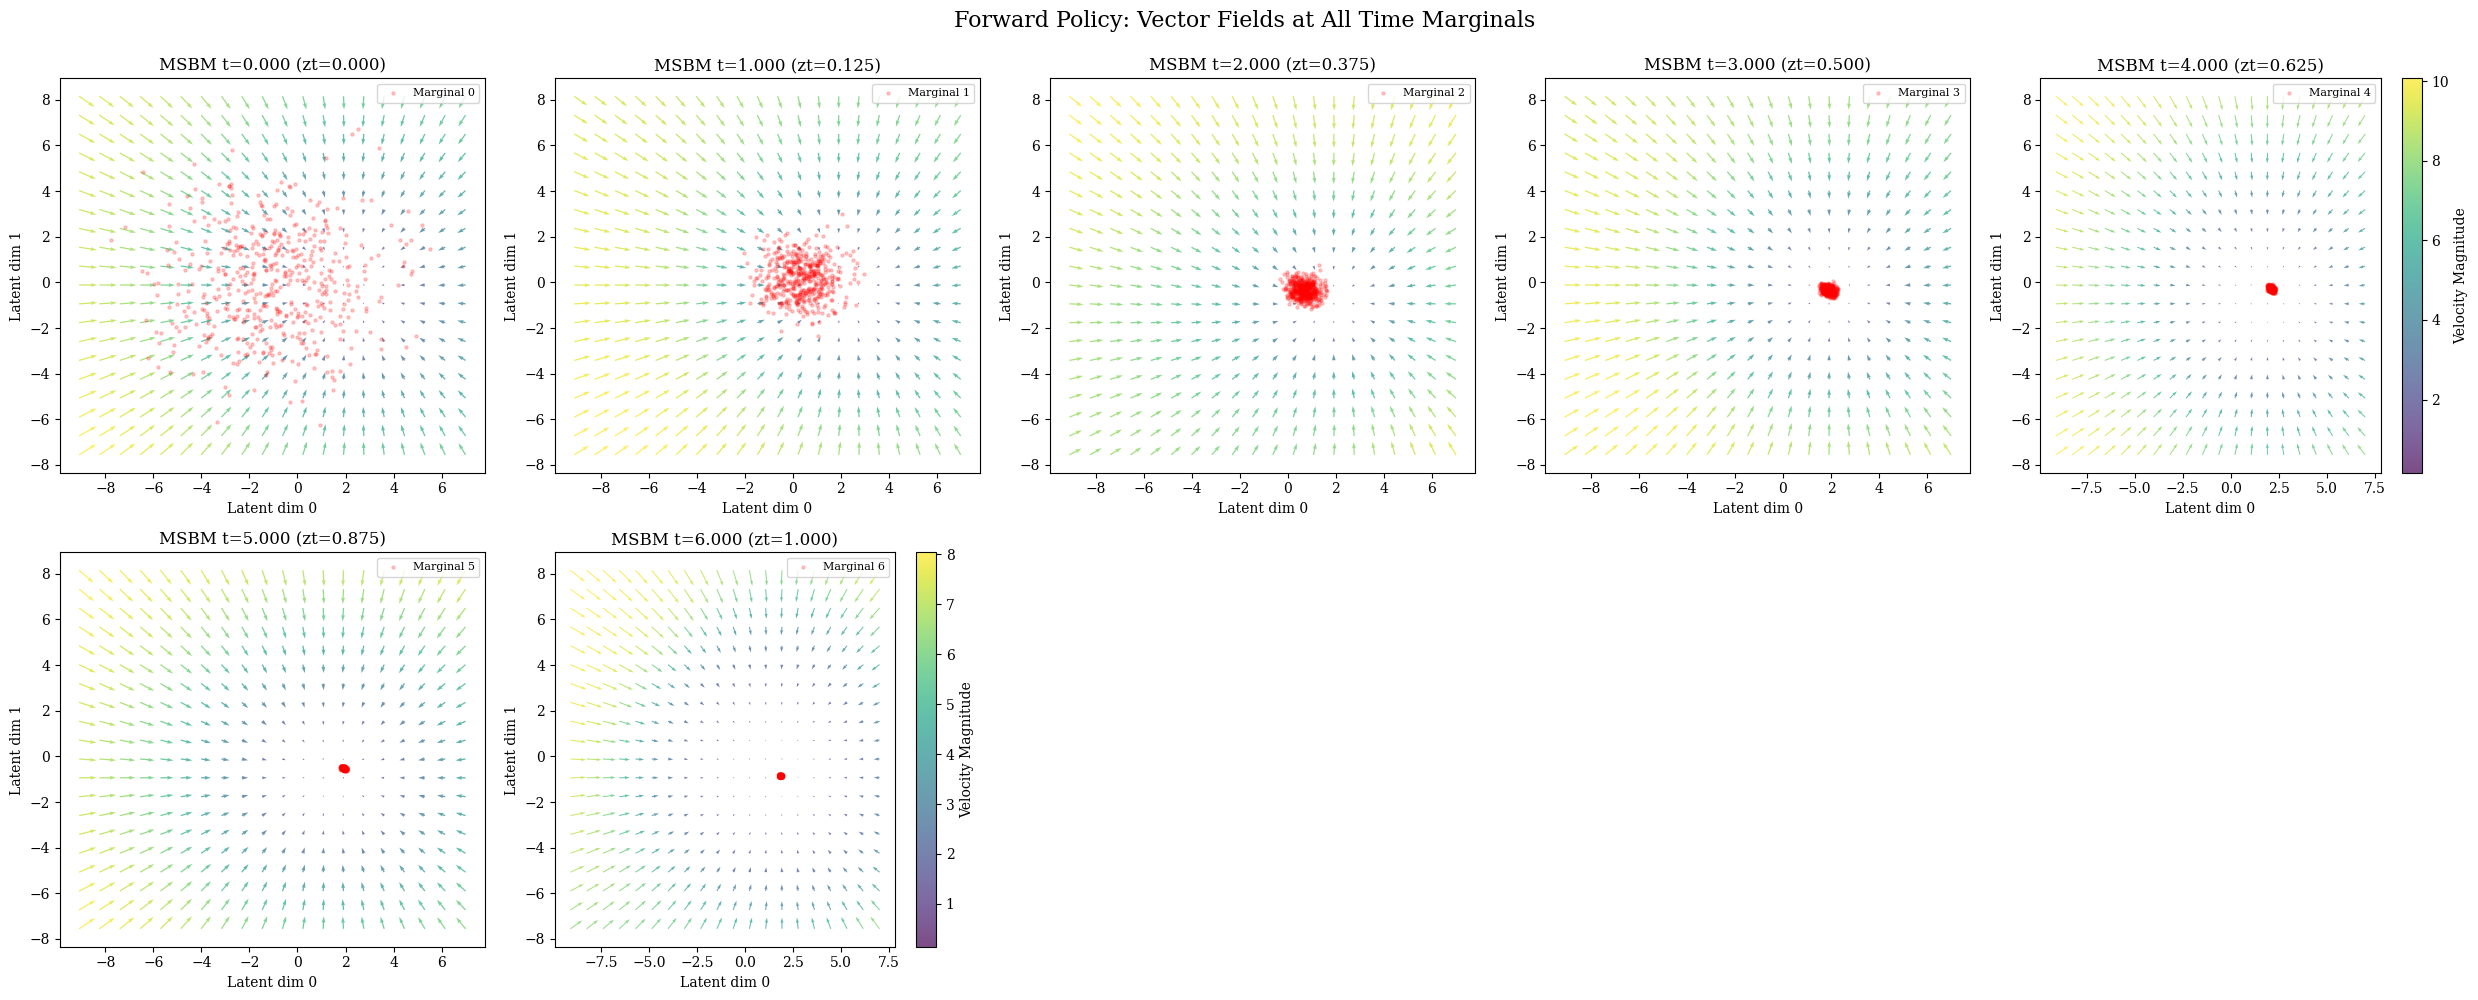

Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/vector_field_forward_all_times.png


In [24]:
# Get all time values from MSBM agent
t_dists = agent.t_dists.detach().cpu().numpy().astype(np.float32)
print(f"Number of time marginals: {len(t_dists)}")
print(f"Time range: [{t_dists[0]:.3f}, {t_dists[-1]:.3f}]")
print(f"Normalized zt range: [{zt_np[0]:.3f}, {zt_np[-1]:.3f}]")
print(f"Correspondence: t_dists[i] maps to latent_data[i] which represents zt[i]")

# Determine subplot layout
n_times = len(t_dists)
n_cols = min(5, n_times)  # Max 5 columns
n_rows = (n_times + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(figsize_per_subplot * n_cols, figsize_per_subplot * n_rows)
)

# Flatten axes for easier indexing
if n_times == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

# Plot vector field at each time marginal
for i, t_val in enumerate(t_dists):
    ax = axes[i]
    # t_dists[i] corresponds to marginal index i
    # which represents the data at normalized time zt_np[i]
    quiv = plot_vector_field_with_magnitude(
        agent.z_f,
        latent_ref,
        float(t_val),
        marginal_idx=i,  # Use the correct marginal index
        zt_val=float(zt_np[i]),  # Show the normalized time
        ax=ax,
        device=device,
        grid_size=grid_size,
        dims=dims,
        show_data=True,
    )
    
    # Add colorbar to the last plot of each row
    if (i + 1) % n_cols == 0 or i == n_times - 1:
        plt.colorbar(quiv, ax=ax, label='Velocity Magnitude')

# Hide extra subplots
for i in range(n_times, len(axes)):
    axes[i].axis('off')

plt.suptitle("Forward Policy: Vector Fields at All Time Marginals", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Save figure
save_path = msbm_dir / "eval" / "vector_field_forward_all_times.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved to {save_path}")

## Backward Policy: Vector Fields at All Time Marginals

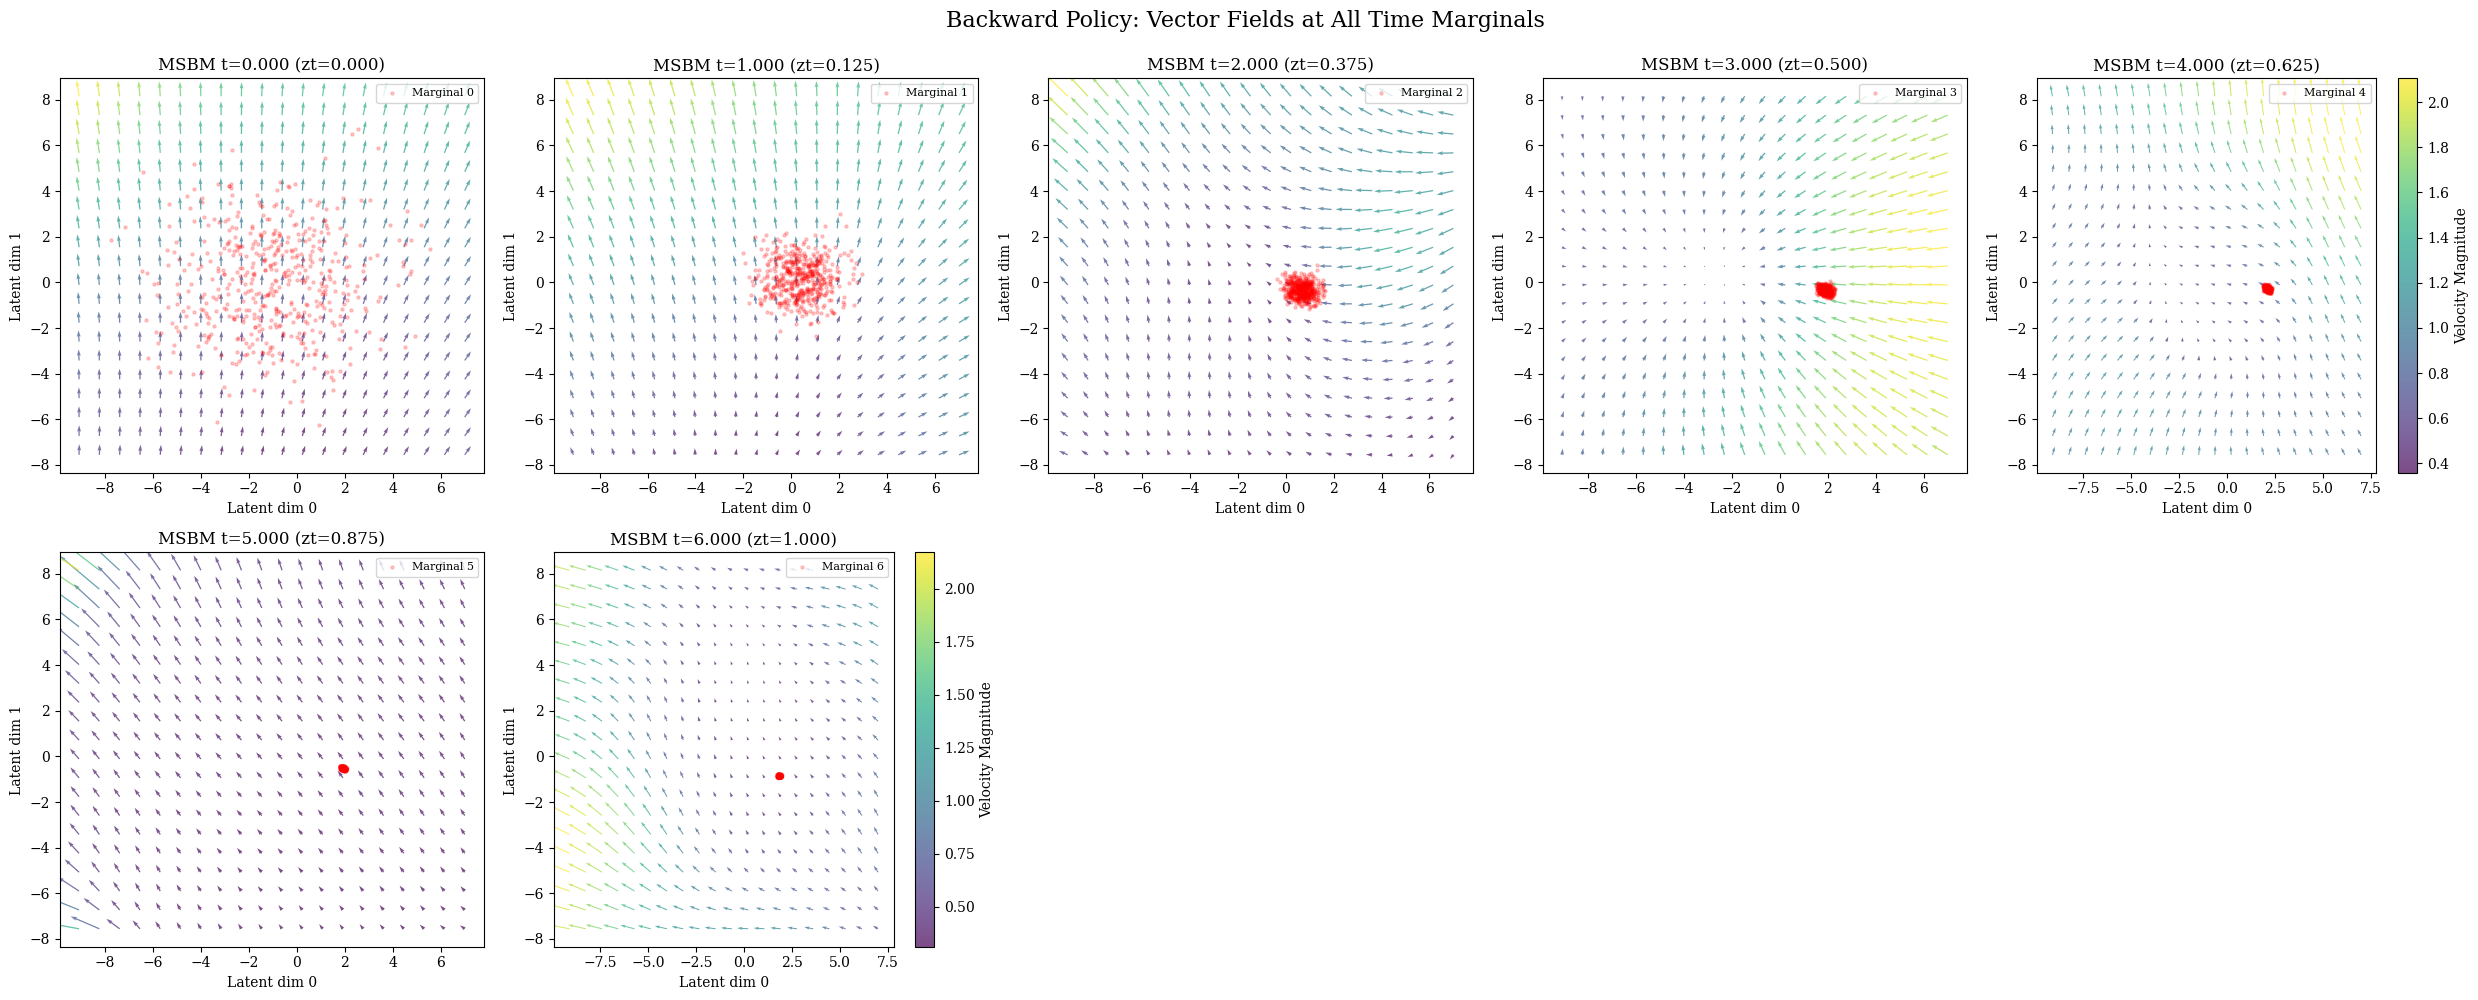

Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/vector_field_backward_all_times.png


In [25]:
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(figsize_per_subplot * n_cols, figsize_per_subplot * n_rows)
)

# Flatten axes for easier indexing
if n_times == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

# Plot vector field at each time marginal
for i, t_val in enumerate(t_dists):
    ax = axes[i]
    # t_dists[i] corresponds to marginal index i
    # which represents the data at normalized time zt_np[i]
    quiv = plot_vector_field_with_magnitude(
        agent.z_b,
        latent_ref,
        float(t_val),
        marginal_idx=i,  # Use the correct marginal index
        zt_val=float(zt_np[i]),  # Show the normalized time
        ax=ax,
        device=device,
        grid_size=grid_size,
        dims=dims,
        show_data=True,
    )
    
    # Add colorbar to the last plot of each row
    if (i + 1) % n_cols == 0 or i == n_times - 1:
        plt.colorbar(quiv, ax=ax, label='Velocity Magnitude')

# Hide extra subplots
for i in range(n_times, len(axes)):
    axes[i].axis('off')

plt.suptitle("Backward Policy: Vector Fields at All Time Marginals", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Save figure
save_path = msbm_dir / "eval" / "vector_field_backward_all_times.png"
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved to {save_path}")

Selected 3 time points:
  Index 0: t=0.000, zt=0.000
  Index 5: t=5.000, zt=0.875
  Index 6: t=6.000, zt=1.000


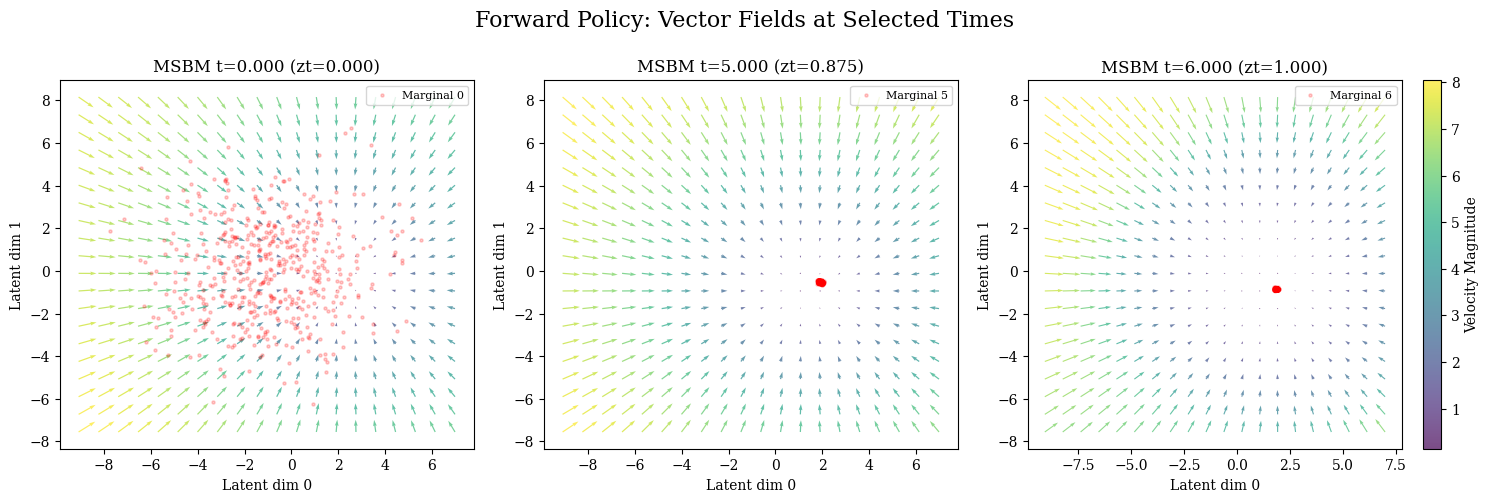

Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/vector_field_forward_selected_times.png


In [26]:
# Select specific time indices (e.g., every 5th time point)
selected_indices = list(range(0, len(t_dists), 5))
if (len(t_dists) - 1) not in selected_indices:
    selected_indices.append(len(t_dists) - 1)  # Always include last time

selected_times = t_dists[selected_indices]
selected_zt = zt_np[selected_indices]
print(f"Selected {len(selected_times)} time points:")
for idx, (t_val, zt_val) in zip(selected_indices, zip(selected_times, selected_zt)):
    print(f"  Index {idx}: t={t_val:.3f}, zt={zt_val:.3f}")

# Plot forward policy at selected times
n_selected = len(selected_times)
n_cols_sel = min(4, n_selected)
n_rows_sel = (n_selected + n_cols_sel - 1) // n_cols_sel

fig, axes = plt.subplots(
    n_rows_sel, n_cols_sel,
    figsize=(figsize_per_subplot * n_cols_sel, figsize_per_subplot * n_rows_sel)
)

if n_selected == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

for plot_idx, (marginal_idx, t_val, zt_val) in enumerate(zip(selected_indices, selected_times, selected_zt)):
    ax = axes[plot_idx]
    quiv = plot_vector_field_with_magnitude(
        agent.z_f,
        latent_ref,
        float(t_val),
        marginal_idx=marginal_idx,  # Use the correct marginal index
        zt_val=float(zt_val),
        ax=ax,
        device=device,
        grid_size=grid_size,
        dims=dims,
        show_data=True,
    )
    
    if (plot_idx + 1) % n_cols_sel == 0 or plot_idx == n_selected - 1:
        plt.colorbar(quiv, ax=ax, label='Velocity Magnitude', fraction=0.046)

for i in range(n_selected, len(axes)):
    axes[i].axis('off')

plt.suptitle("Forward Policy: Vector Fields at Selected Times", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

save_path = msbm_dir / "eval" / "vector_field_forward_selected_times.png"
fig.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Saved to {save_path}")

## Summary

All visualizations have been generated and saved to the `eval/` directory:

In [34]:
# Decode latent marginals to ambient space
print("Decoding latent marginals to ambient space...")
print(f"  Using zt (autoencoder times): {zt_np}")

# Decode all test marginals
ambient_decoded = agent.decode_trajectories(latent_ref, zt_np)  # (T, N, D)

print(f"✓ Decoded to ambient space")
print(f"  Shape: {ambient_decoded.shape}")
print(f"  Ambient dimension: {ambient_decoded.shape[2]}")

# Get reference ambient data for comparison
ambient_reference = x_test[:, :, :]  # (T, N, D)
print(f"  Reference shape: {ambient_reference.shape}")

Decoding latent marginals to ambient space...
  Using zt (autoencoder times): [0.    0.125 0.375 0.5   0.625 0.875 1.   ]
✓ Decoded to ambient space
  Shape: (7, 500, 376)
  Ambient dimension: 376
  Reference shape: (7, 1000, 376)


## Ambient Space Reconstruction

Decode latent marginals back to ambient space to visualize PCA coefficients.

Creating ambient space visualizations...
✓ Ambient PCA: 376D → 2D
  Explained variance: 0.0595
✓ Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/ambient_marginals_comparison_pca.png


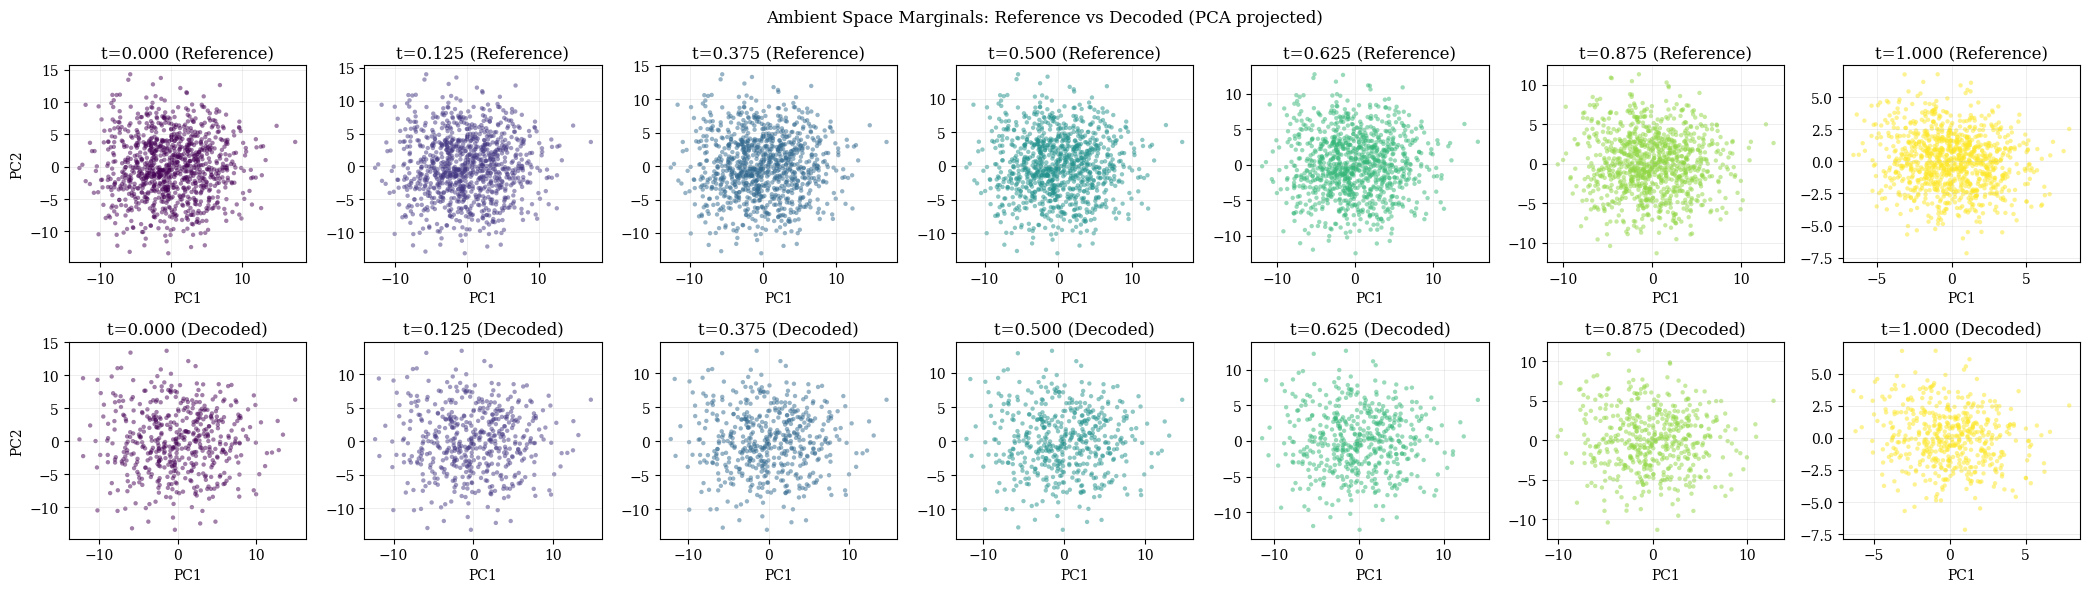

In [36]:
# Visualize ambient space marginals (PCA projection for high-dim)
print("Creating ambient space visualizations...")

# Fit PCA on ambient data for 2D visualization
ambient_all_data = ambient_reference.reshape(-1, ambient_reference.shape[2])
ambient_pca = PCA(n_components=2)
ambient_pca.fit(ambient_all_data)

print(f"✓ Ambient PCA: {ambient_reference.shape[2]}D → 2D")
print(f"  Explained variance: {ambient_pca.explained_variance_ratio_.sum():.4f}")

# Create comparison figure: Reference vs Decoded
fig, axes = plt.subplots(2, len(zt_np), figsize=(3*len(zt_np), 6))
if len(zt_np) == 1:
    axes = axes.reshape(-1, 1)

colors_marginal = cm.viridis(np.linspace(0, 1, len(zt_np)))

for i, t_val in enumerate(zt_np):
    # Reference marginal
    ax = axes[0, i]
    ref_proj = ambient_pca.transform(ambient_reference[i, :, :])
    ax.scatter(ref_proj[:, 0], ref_proj[:, 1], c=[colors_marginal[i]], 
               alpha=0.5, s=10, edgecolors='none', label='Reference')
    ax.set_title(f't={t_val:.3f} (Reference)')
    ax.set_xlabel('PC1')
    if i == 0:
        ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3, linewidth=0.5)
    
    # Decoded marginal
    ax = axes[1, i]
    dec_proj = ambient_pca.transform(ambient_decoded[i, :, :])
    ax.scatter(dec_proj[:, 0], dec_proj[:, 1], c=[colors_marginal[i]], 
               alpha=0.5, s=10, edgecolors='none', label='Decoded')
    ax.set_title(f't={t_val:.3f} (Decoded)')
    ax.set_xlabel('PC1')
    if i == 0:
        ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3, linewidth=0.5)

plt.suptitle('Ambient Space Marginals: Reference vs Decoded (PCA projected)', fontsize=12)
plt.tight_layout()

save_path = msbm_dir / "eval" / "ambient_marginals_comparison_pca.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"✓ Saved to {save_path}")
plt.show()

## PCA-Projected Vector Fields and Marginals

In [37]:
# Fit PCA to all latent data
print("Fitting PCA to latent trajectories...")
all_latent_data = latent_ref.reshape(-1, latent_ref.shape[2])  # (T*N, K)
pca = PCA(n_components=2)
pca.fit(all_latent_data)

print(f"✓ PCA fitted with {latent_ref.shape[2]}D → 2D")
print(f"  Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.4f}, PC2={pca.explained_variance_ratio_[1]:.4f}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Fitting PCA to latent trajectories...
✓ PCA fitted with 376D → 2D
  Explained variance ratio: PC1=0.5764, PC2=0.1569
  Total variance explained: 0.7333


In [38]:
# Sample points from latent space and evaluate velocity
n_sample_points = 500
sample_indices = rng.choice(n_infer, size=n_sample_points, replace=True)
sample_marginal_indices = rng.choice(len(t_dists), size=n_sample_points, replace=True)

# Collect sampled points and their velocities
sampled_positions = []
sampled_velocities_f = []
sampled_velocities_b = []
sampled_times_msbm = []
sampled_times_zt = []

for i in range(n_sample_points):
    marg_idx = sample_marginal_indices[i]
    point_idx = sample_indices[i]
    
    # Get latent position
    y = latent_ref[marg_idx, point_idx, :]  # (K,)
    sampled_positions.append(y)
    
    # Get times
    t_msbm = float(t_dists[marg_idx])
    t_zt_val = float(zt_np[marg_idx])
    sampled_times_msbm.append(t_msbm)
    sampled_times_zt.append(t_zt_val)
    
    # Evaluate velocities
    with torch.no_grad():
        y_tensor = torch.from_numpy(y[None, :]).float().to(device)
        t_tensor = torch.full((1,), t_msbm, device=device)
        
        v_f = agent.z_f(y_tensor, t=t_tensor).cpu().numpy()[0]
        v_b = agent.z_b(y_tensor, t=t_tensor).cpu().numpy()[0]
        
        sampled_velocities_f.append(v_f)
        sampled_velocities_b.append(v_b)

sampled_positions = np.array(sampled_positions)  # (n_sample, K)
sampled_velocities_f = np.array(sampled_velocities_f)  # (n_sample, K)
sampled_velocities_b = np.array(sampled_velocities_b)  # (n_sample, K)
sampled_times_zt = np.array(sampled_times_zt)  # (n_sample,)

# Project to PCA space
positions_pca = pca.transform(sampled_positions)  # (n_sample, 2)
velocities_f_pca = sampled_velocities_f @ pca.components_.T  # (n_sample, 2)
velocities_b_pca = sampled_velocities_b @ pca.components_.T  # (n_sample, 2)

print(f"✓ Sampled and evaluated {n_sample_points} points")
print(f"  positions_pca.shape: {positions_pca.shape}")
print(f"  velocities_f_pca.shape: {velocities_f_pca.shape}")

✓ Sampled and evaluated 500 points
  positions_pca.shape: (500, 2)
  velocities_f_pca.shape: (500, 2)


## PCA Projection of Latent Space

For high-dimensional latent spaces, we project to 2D using PCA for visualization.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


✓ Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/pca_backward_comprehensive.png


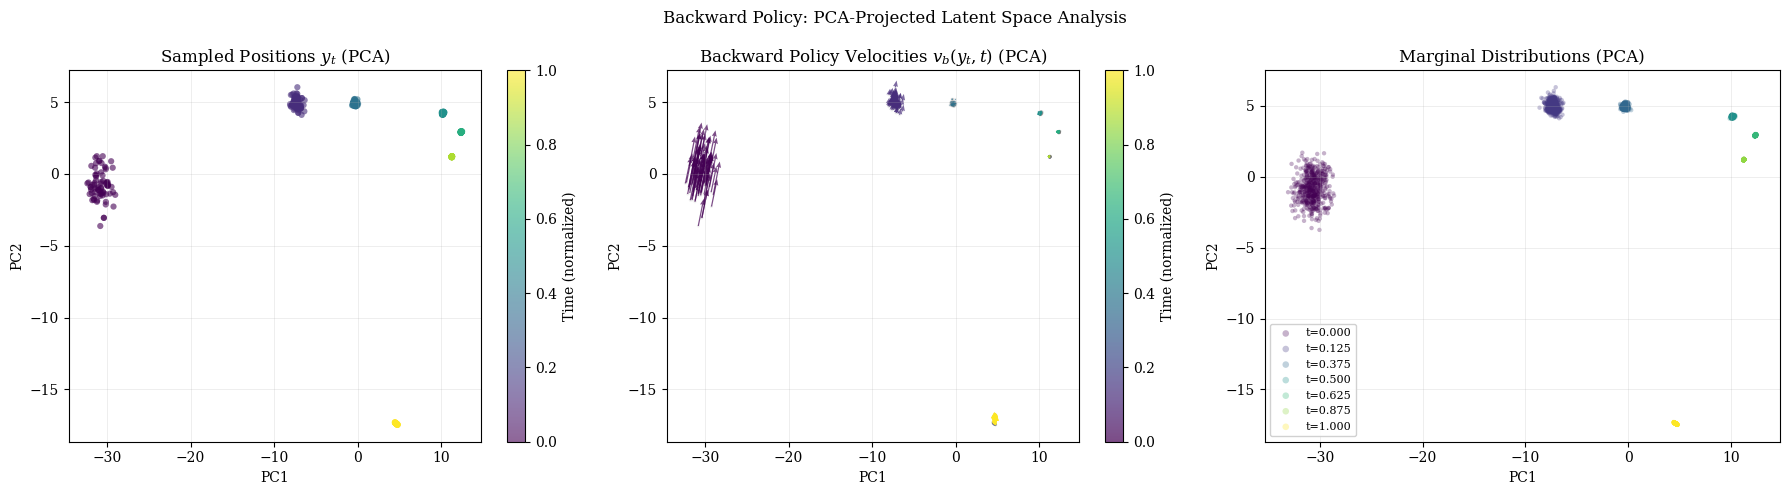

In [39]:
# Create comprehensive PCA visualization (Backward Policy)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Sampled Positions (colored by time)
ax = axes[0]
sc = ax.scatter(positions_pca[:, 0], positions_pca[:, 1], c=sampled_times_zt, 
                cmap='viridis', alpha=0.6, s=20, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax, label='Time (normalized)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Sampled Positions $y_t$ (PCA)')
ax.grid(True, alpha=0.3, linewidth=0.5)

# Panel 2: Velocity Field (Backward Policy)
ax = axes[1]
# Background context points
ax.scatter(positions_pca[:, 0], positions_pca[:, 1], c='gray', s=5, alpha=0.1, edgecolors='none')
# Quiver plot of velocities
Q = ax.quiver(
    positions_pca[:, 0], positions_pca[:, 1],
    velocities_b_pca[:, 0], velocities_b_pca[:, 1],
    sampled_times_zt, cmap='viridis',
    angles='xy', scale_units='xy', scale=20, width=0.003, headwidth=4, alpha=0.7
)
cbar = plt.colorbar(Q, ax=ax, label='Time (normalized)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Backward Policy Velocities $v_b(y_t, t)$ (PCA)')
ax.grid(True, alpha=0.3, linewidth=0.5)

# Panel 3: Marginal Distributions
ax = axes[2]
colors_marginal = cm.viridis(np.linspace(0, 1, len(zt_np)))
for i in range(len(zt_np)):
    latent_i_pca = pca.transform(latent_ref[i, :, :])
    ax.scatter(
        latent_i_pca[:, 0], latent_i_pca[:, 1],
        color=colors_marginal[i], s=10, alpha=0.3,
        label=f't={zt_np[i]:.3f}', edgecolors='none'
    )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Marginal Distributions (PCA)')
ax.legend(fontsize=8, markerscale=1.5, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=0.5)

plt.suptitle('Backward Policy: PCA-Projected Latent Space Analysis', fontsize=12, y=0.98)
plt.tight_layout()

# Save
save_path = msbm_dir / "eval" / "pca_backward_comprehensive.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"✓ Saved to {save_path}")
plt.show()

✓ Saved to /data1/jy384/research/MMSFM/results/2026-01-26T18-10-14-42/eval/pca_forward_comprehensive.png


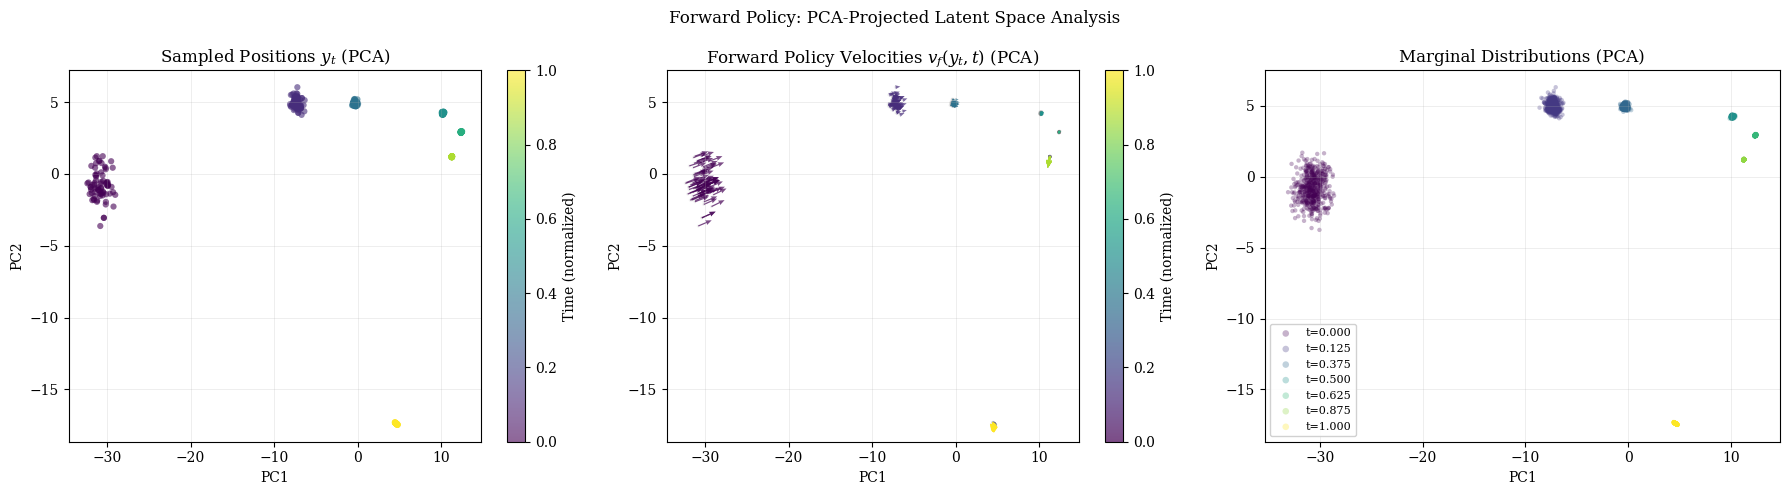

In [40]:
# Create comprehensive PCA visualization (Forward Policy)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Sampled Positions (colored by time)
ax = axes[0]
sc = ax.scatter(positions_pca[:, 0], positions_pca[:, 1], c=sampled_times_zt, 
                cmap='viridis', alpha=0.6, s=20, edgecolors='none')
cbar = plt.colorbar(sc, ax=ax, label='Time (normalized)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Sampled Positions $y_t$ (PCA)')
ax.grid(True, alpha=0.3, linewidth=0.5)

# Panel 2: Velocity Field (Forward Policy)
ax = axes[1]
# Background context points
ax.scatter(positions_pca[:, 0], positions_pca[:, 1], c='gray', s=5, alpha=0.1, edgecolors='none')
# Quiver plot of velocities
Q = ax.quiver(
    positions_pca[:, 0], positions_pca[:, 1],
    velocities_f_pca[:, 0], velocities_f_pca[:, 1],
    sampled_times_zt, cmap='viridis',
    angles='xy', scale_units='xy', scale=20, width=0.003, headwidth=4, alpha=0.7
)
cbar = plt.colorbar(Q, ax=ax, label='Time (normalized)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Forward Policy Velocities $v_f(y_t, t)$ (PCA)')
ax.grid(True, alpha=0.3, linewidth=0.5)

# Panel 3: Marginal Distributions
ax = axes[2]
colors_marginal = cm.viridis(np.linspace(0, 1, len(zt_np)))
for i in range(len(zt_np)):
    latent_i_pca = pca.transform(latent_ref[i, :, :])
    ax.scatter(
        latent_i_pca[:, 0], latent_i_pca[:, 1],
        color=colors_marginal[i], s=10, alpha=0.3,
        label=f't={zt_np[i]:.3f}', edgecolors='none'
    )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Marginal Distributions (PCA)')
ax.legend(fontsize=8, markerscale=1.5, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=0.5)

plt.suptitle('Forward Policy: PCA-Projected Latent Space Analysis', fontsize=12, y=0.98)
plt.tight_layout()

# Save
save_path = msbm_dir / "eval" / "pca_forward_comprehensive.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"✓ Saved to {save_path}")
plt.show()

## Summary Statistics

In [ ]:
# Compute velocity magnitude statistics across all times
print("\n" + "="*60)
print("Velocity Magnitude Statistics")
print("="*60)

for policy_name, policy in [("Forward", agent.z_f), ("Backward", agent.z_b)]:
    print(f"\n{policy_name} Policy:")
    print("-" * 40)
    
    magnitudes_by_time = []
    
    for i, t_val in enumerate(t_dists):
        # Use the correct marginal index i for the data at MSBM time t_val
        sample_points = latent_ref[i, :, :]  # (N, K)
        
        with torch.no_grad():
            y = torch.from_numpy(sample_points).float().to(device)
            t = torch.full((len(y),), float(t_val), device=device)
            v = policy(y, t=t).cpu().numpy()
        
        mag = np.linalg.norm(v, axis=1)
        magnitudes_by_time.append(mag)
        
        print(f"  Marginal {i}: MSBM t={t_val:.3f}, zt={zt_np[i]:.3f} | "
              f"mean={mag.mean():.4f}, std={mag.std():.4f}, "
              f"min={mag.min():.4f}, max={mag.max():.4f}")
    
    all_mags = np.concatenate(magnitudes_by_time)
    print(f"\n  Overall: mean={all_mags.mean():.4f}, std={all_mags.std():.4f}")

print("\n" + "="*60)


Velocity Magnitude Statistics

Forward Policy:
----------------------------------------
  Marginal 0: MSBM t=0.000, zt=0.000 | mean=40.9071, std=1.0520, min=37.5970, max=44.1810
  Marginal 1: MSBM t=1.000, zt=0.125 | mean=14.5693, std=0.5461, min=12.7371, max=15.9999
  Marginal 2: MSBM t=2.000, zt=0.375 | mean=8.8089, std=3.0334, min=5.2827, max=19.1325
  Marginal 3: MSBM t=3.000, zt=0.500 | mean=7.1181, std=0.1302, min=6.7873, max=7.5160
  Marginal 4: MSBM t=4.000, zt=0.625 | mean=4.0523, std=0.0670, min=3.8831, max=4.3621
  Marginal 5: MSBM t=5.000, zt=0.875 | mean=16.2615, std=0.3589, min=15.1406, max=17.1833
  Marginal 6: MSBM t=6.000, zt=1.000 | mean=12.5183, std=0.0358, min=12.4065, max=12.6224

  Overall: mean=14.8908, std=11.4024

Backward Policy:
----------------------------------------
  Marginal 0: MSBM t=0.000, zt=0.000 | mean=49.4724, std=3.8672, min=41.1967, max=59.3023
  Marginal 1: MSBM t=1.000, zt=0.125 | mean=10.1316, std=0.5908, min=7.7601, max=11.4873
  Marginal 2:

In [ ]:
print("="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print(f"\n📁 Output directory: {msbm_dir / 'eval'}\n")

print("✓ Latent Space Visualizations (High-dim vector fields):")
print("  - vector_field_forward_all_times.png")
print("  - vector_field_backward_all_times.png")
print("  - vector_field_forward_selected_times.png")

print("\n✓ PCA-Projected Visualizations (Following visualize_conditional_flow_pca.py):")
print("  - pca_forward_comprehensive.png   (Positions, Velocities, Marginals)")
print("  - pca_backward_comprehensive.png  (Positions, Velocities, Marginals)")

print("\n✓ Ambient Space Reconstructions:")
print("  - ambient_marginals_comparison_pca.png  (Reference vs Decoded)")

print("\n📊 Diagnostic Information:")
print(f"  - Number of marginals: {len(zt_np)}")
print(f"  - Latent dimension: {latent_ref.shape[2]}")
print(f"  - Ambient dimension: {ambient_decoded.shape[2]}")
print(f"  - PCA variance (latent): {pca.explained_variance_ratio_.sum():.3f}")
print(f"  - PCA variance (ambient): {ambient_pca.explained_variance_ratio_.sum():.3f}")

print("\n🎨 Plot format: Publication-ready (Times New Roman font, 300 DPI)")
print("="*70)